In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from astropy.units import jupiterMass, jupiterRad, solMass, solRad, AU

# Parameters wanted:
   *  Mass, radius, orbital period, host star metallicity, eccentricity, equilibrium temperature.
   * Semimajor axis a may be relevant too

In [4]:
file_US="/home/bolacha/University/Project/code/data-example/all_data_US.rdb"
file_EU="/home/bolacha/University/Project/code/data-example/all_data_EU.rdb"

In [5]:
def read_file(file, removeNaN=False, params=0):
    database = np.genfromtxt(file_EU, comments="--", skip_header=4,
                            dtype=None, delimiter="\t", encoding=None)
    df = pd.DataFrame(database)
    with open(file) as f:
        columns = f.readline()
    columns = columns.replace("\n", "")
    columns = columns.split('\t')
    n = len(columns)
    df = df.iloc[:,:n]
    df.columns = columns
    df = pd.DataFrame.set_index(df,keys='obj_id_catname')
    if params != 0:
        df = df[params]
    if removeNaN == True:
        df = pd.DataFrame.dropna(df,axis=0, how='any')
    return df
           
d_US_test = read_file(file_US)
d_US_test

,db_info_name,pub_info_detectiontype,obj_phys_mass_mjup,obj_phys_msini_mjup,obj_phys_radius_rjup,obj_orb_period_day,obj_orb_a_au,obj_orb_omega_deg_errmin,sys_nplanets,obj_orb_ecc,...,obj_orb_a_au_errmax,obj_parent_phys_feh_errmax,pub_info_discovered_year,pub_info_reference,obj_parent_phys_teff_k_errmin,obj_insolation_earthfl,obj_parent_phys_lum_lsun,obj_parent_age_gyr,obj_parent_mv,obj_phys_eq_temp_k
obj_id_catname,,,,,,,,,,,,,,,,,,,,,
BD+15 2940 b,Exoplanet.eu,Radial Velocity,NaN,1.1100,NaN,137.480000,0.53900,33.0,NaN,0.26,...,NaN,NaN,2013,False,117.0,NaN,NaN,NaN,NaN,NaN
CoRoT-12 b,Exoplanet.eu,Transit,0.917,NaN,1.44,2.828042,0.04016,27.0,NaN,0.07,...,0.00092,NaN,2010,False,80.0,NaN,NaN,NaN,NaN,NaN
GJ 667 C e,Exoplanet.eu,Radial Velocity,NaN,0.0085,NaN,62.240000,0.21300,360.0,NaN,0.02,...,0.02000,NaN,2013,False,NaN,NaN,NaN,NaN,NaN,NaN
HD 113337 c,Exoplanet.eu,Radial Velocity,NaN,7.2000,NaN,3264.700000,4.80000,13.0,NaN,0.18,...,0.23000,NaN,2018,False,16.0,NaN,NaN,NaN,NaN,NaN
HD 120084 b,Exoplanet.eu,Radial Velocity,NaN,4.5000,NaN,2082.000000,4.30000,9.0,NaN,0.66,...,NaN,NaN,2013,False,22.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WASP-167 b,Exoplanet.eu,Transit,8.000,NaN,1.51,2.021959,0.03650,NaN,NaN,NaN,...,0.00060,NaN,2017,False,68.0,NaN,NaN,NaN,NaN,NaN
WASP-25 b,Exoplanet.eu,Transit,0.580,NaN,1.26,3.764830,0.04740,NaN,NaN,0.00,...,0.00040,NaN,2010,False,100.0,NaN,NaN,NaN,NaN,NaN
WD 0837+185 B,Exoplanet.eu,Radial Velocity,30.000,25.0000,NaN,0.175000,0.00600,NaN,NaN,NaN,...,NaN,NaN,2012,False,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
d_US_test.columns

Index(['db_info_name', 'pub_info_detectiontype', 'obj_phys_mass_mjup',
       'obj_phys_msini_mjup', 'obj_phys_radius_rjup', 'obj_orb_period_day',
       'obj_orb_a_au', 'obj_orb_omega_deg_errmin', 'sys_nplanets',
       'obj_orb_ecc', 'obj_parent_phys_mass_msun_errmax', 'pub_info_updated',
       'obj_orb_a_au_errmin', 'obj_orb_bigomega_deg_errmax',
       'obj_orb_angdist_arcsec_errmin', 'obj_orb_angdist_arcsec',
       'obj_orb_inc_deg_errmin', 'obj_orb_stardistance_pc',
       'obj_parent_phys_teff_k', 'obj_orb_period_day_errmax',
       'obj_orb_inc_deg_errmax', 'obj_orb_angdist_arcsec_errmax',
       'obj_orb_bigomega_deg_errmin', 'obj_parent_phys_radius_rsun',
       'obj_parent_phys_mass_msun', 'obj_orb_bigomega_deg',
       'obj_orb_period_day_errmin', 'obj_parent_phys_feh',
       'obj_orb_stardistance_pc_errmin', 'obj_orb_tperi_day_errmin',
       'obj_stellar_magv', 'obj_orb_k_mps_errmin', 'obj_orb_k_mps_errmax',
       'obj_pos_alpha_deg', 'obj_parent_phys_mass_msun_errmin

In [7]:
param_MP=['obj_orb_period_day','obj_phys_mass_mjup']

#for the first clustering trial -- mass vs orbital period
d_US_MP, d_EU_MP = read_file(file_US,True,param_MP), read_file(file_EU,True,param_MP)
M_US_MP, P_US_MP = d_US_MP['obj_phys_mass_mjup'], d_US_MP['obj_orb_period_day']
M_EU_MP, P_EU_MP = d_EU_MP['obj_phys_mass_mjup'], d_EU_MP['obj_orb_period_day']

We first aim to find three separate groups:
* Hot jupiters: P $\lesssim 7$ d, $M/M_J \leq 12$; centered around $\sim 1 M_J$ and $P \sim 3$ d; 
* Eccentric giants: $10^2 d \lesssim P \lesssim 10^4 d$; $1 \lesssim M/M_J \leq 10$.
* Ungiants: $P \leq 100 d$; $ M/M_J \lesssim 0.07$ and $R \lesssim 0.35 R_J$

$\rightarrow$ <u>Task 1:</u>  mass vs period.

# mass vs orbital period

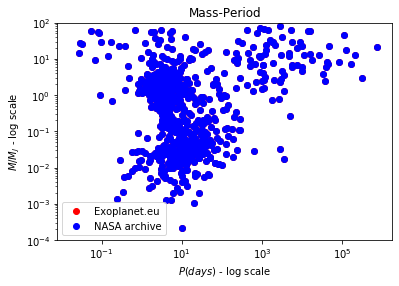

In [8]:
plt.scatter(P_EU_MP, M_EU_MP,label = "Exoplanet.eu",c='r')
plt.scatter(P_US_MP, M_US_MP,label = "NASA archive",c='b')
plt.ylabel(r"$M/M_J$ - log scale")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$P (days)$ - log scale")
plt.ylim(10e-5,10e1)
plt.legend()
plt.title(r"Mass-Period")
plt.show()

Which is a first visualization for the relationship between orbital period and mass, in the full range we're studying, and also reproduces the figure in my document.

We can already see the three separate groups.

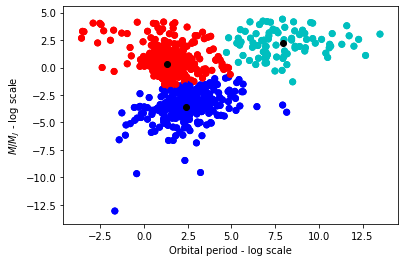

In [9]:
kmeans = KMeans(n_clusters=3).fit(np.log(d_US_MP))
centroids, labels = kmeans.cluster_centers_, kmeans.labels_
colors = ['r','b','c']
label_color=[]
for l in labels:
    label_color=np.append(label_color,colors[l])

plt.scatter(np.log(P_US_MP),np.log(M_US_MP),c=label_color)
plt.scatter(np.log(P_EU_MP),np.log(M_EU_MP),c=label_color)
plt.scatter(centroids[:, 0],centroids[:, 1],color='k')
plt.xlabel('Orbital period - log scale')
plt.ylabel(r'$M/M_J$ - log scale')
plt.show()

Using a log scale, the three groups are easily found.

# mass-radius-temperature

* Calculating temperature

From Laughlin & Lissauer (2015) and  S. Seager (2011):
$$
T_{\mathrm{eq}}=[f(1-A)]^{1/4} \left(\frac{R_{\star}}{2 a}\right)^{1 / 2} \frac{T_{\star}}{\left(1-e^{2}\right)^{1 / 8}}
$$
Params meeded: $R_{\star}, a, T_{\star}, e$

In [10]:
param_Teff=['obj_phys_mass_mjup', 'obj_phys_radius_rjup',
           'obj_parent_phys_teff_k','obj_orb_ecc','obj_orb_a_au','obj_parent_phys_radius_rsun']

d_US_MRT, d_EU_MRT = read_file(file_US, True, param_Teff), read_file(file_EU, True, param_Teff)

In [11]:
#with the help of solene's code
def getTeqpl(Teffst, aR, ecc, A=0, f=1/4.): 
    return Teffst * (f * (1 - A))**(1 / 4.) * np.sqrt(1 / aR) / (1 - ecc**2)**(1/8.)

def add_temp_eq_dataset(dataset):
    semi_major_axis = dataset['obj_orb_a_au'] * AU.to('solRad')
    teq_planet = [getTeqpl(teff, a/rad, ecc)
                  for teff, a, rad, ecc,
                  in zip(dataset['obj_parent_phys_teff_k'], semi_major_axis,
                         dataset['obj_parent_phys_radius_rsun'], dataset['obj_orb_ecc'])]
    dataset.insert(2, 'temp_eq', teq_planet)
    return dataset

In [12]:
d_US_MRT = add_temp_eq_dataset(d_US_MRT)
d_US_MRT = add_temp_eq_dataset(d_EU_MRT)

In [13]:
d_US_MRT

,obj_phys_mass_mjup,obj_phys_radius_rjup,temp_eq,obj_parent_phys_teff_k,obj_orb_ecc,obj_orb_a_au,obj_parent_phys_radius_rsun
obj_id_catname,,,,,,,
CoRoT-12 b,0.917,1.4400,1443.447751,5675.0,0.0700,0.04016,1.116
TOI-216 b,0.082,0.7670,585.541044,5045.0,0.1050,0.12930,0.747
WASP-46 b,2.101,1.3100,1658.626403,5620.0,0.0000,0.02448,0.917
CoRoT-13 b,1.308,0.8850,1275.735837,5945.0,0.0000,0.05100,1.010
HATS-31 b,0.880,1.6400,1837.493123,6050.0,0.2330,0.04780,1.870
...,...,...,...,...,...,...,...
K2-39 b,0.125,0.7300,1867.373030,4881.0,0.1520,0.06200,3.880
Kepler-107 d,0.012,0.0767,1157.520509,5851.0,0.0000,0.08377,1.410
Kepler-1647 (AB) b,1.520,1.0600,243.002426,6210.0,0.0581,2.72050,1.790


In [14]:
M_US, R_US, Teq_US = d_US_MRT['obj_phys_mass_mjup'], d_US_MRT['obj_phys_radius_rjup'], d_US_MRT['temp_eq']
M_EU, R_EU, Teq_EU = d_EU_MRT['obj_phys_mass_mjup'], d_EU_MRT['obj_phys_radius_rjup'], d_EU_MRT['temp_eq']

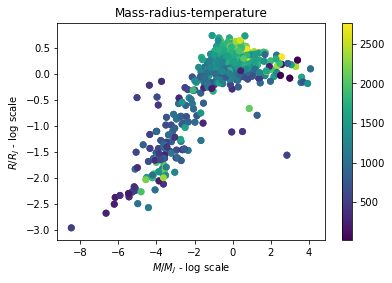

In [19]:
c1 = plt.cm.BuPu((Teq_US-np.min(Teq_US))/np.ptp(Teq_US))
c2 = plt.cm.BuPu((Teq_EU-np.min(Teq_EU))/np.ptp(Teq_US))
plt.scatter(np.log(M_US), np.log(R_US), c = Teq_US, s=30, linewidths=1.5, marker='o')
plt.scatter(np.log(M_EU), np.log(R_EU), c = Teq_EU, s=30, linewidths=1.5, marker='o')
plt.xlabel(r"$M/M_J$ - log scale")
plt.ylabel(r"$R/R_J$ - log scale")
plt.title(r"Mass-radius-temperature")
plt.colorbar()
plt.show()